In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
import pandas as pd

import pycomlink as pycml

# Load example data and look at one CML

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [4]:
data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (channel_id: 2, cml_id: 500, time: 15840)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object 'FY0013_2_FY1257_3' ... 'SY8534_2_SY237...
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

We store each CML as item of a list because we want to do the processing per CML.

In [5]:
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

cml = cml_list[0]
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 15840)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
    cml_id            <U17 'FY0013_2_FY1257_3'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (channel_id) float64 2.491e+10 2.592e+10
    polarization      (channel_id) object 'V' 'V'
Data variables:
    rsl               (channel_id, time) float32 ...
    tsl               (channel_id, time) float32 ...

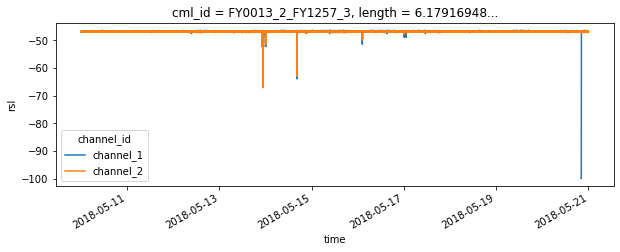

In [6]:
cml.rsl.plot.line(x='time', figsize=(10,3));

# Set default and fill values to NaN and calculate TRSL
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML

In [7]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

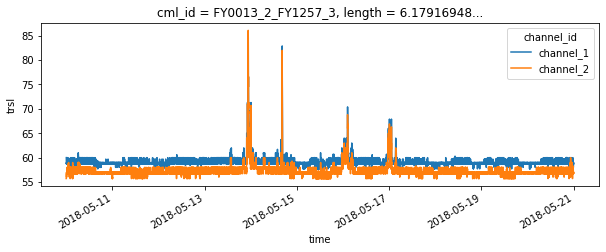

In [8]:
cml = cml_list[0]
cml.trsl.plot.line(x='time', figsize=(10,3));

# Do simple wet-dry classification using a rolling standard deviation 

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. To keep this example short, we use a standard value of 0.8 which is more or less suitable for most CML time series. But please note, that this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html) to get the good performance for CML rainfall estimation.

In [9]:
threshold = 0.8

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > threshold

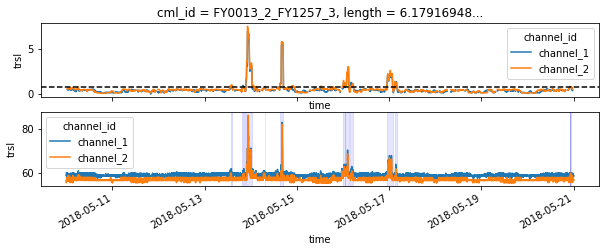

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10,3), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

axs[1].set_title('');

# Determine baseline

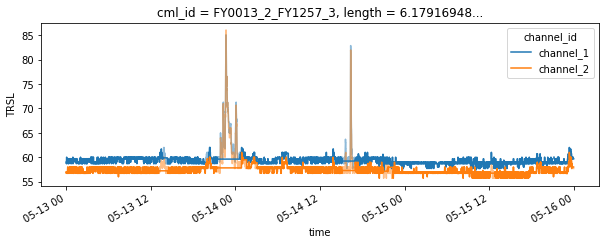

In [11]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

fig, ax = plt.subplots(figsize=(10,3))

cml.trsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time');
plt.gca().set_prop_cycle(None)
plt.ylabel('TRSL');

# Perform wet antenna estimation and compare to uncorrected baseline 

In [12]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [13]:
%matplotlib inline

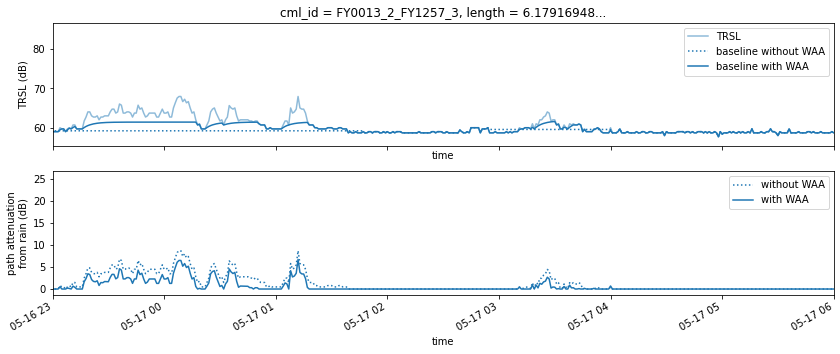

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(14,5), sharex=True)

plt.sca(axs[0])
cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(None)
cml.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
plt.gca().set_prop_cycle(None)
(cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline with WAA');
plt.ylabel('TRSL (dB)')
axs[0].legend()

# estimate WAA and correct baseline
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'] = cml.A.where(cml.A > 0, 0)
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'] = cml.A_no_waa_correct.where(cml.A_no_waa_correct > 0, 0)

plt.sca(axs[1])
cml.A_no_waa_correct.isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA');
plt.gca().set_prop_cycle(None)
cml.A.isel(channel_id=0).plot.line(x='time', label='with WAA');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');
axs[1].legend()

axs[1].set_xlim(pd.to_datetime('2018-05-16 23:00:00'), pd.to_datetime('2018-05-17 06:00:00'));

# Calculate rain rate

In [15]:
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=cml.length, f_GHz=cml.frequency/1e9)

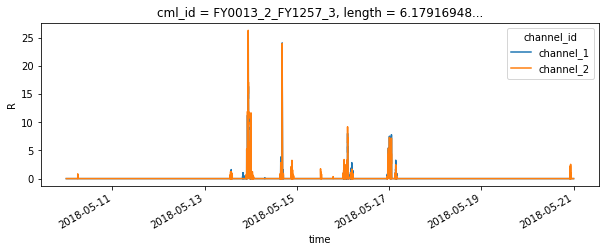

In [16]:
fig, ax = plt.subplots(figsize=(10,3))
cml.R.plot.line(x='time');

# Now do the whole processing for all CMLs 

In [17]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8
    
    cml['wet_fraction'] = (cml.wet==1).sum() / (cml.wet==0).sum()
    
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )
    cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.A, L_km=cml.length, f_GHz=cml.frequency/1e9,
   )

100%|██████████| 500/500 [00:48<00:00, 10.37it/s]


# Find CMLs that show erratic behavior 

Find the CMLs that have a very high ratio of wet/dry data. For the 10-day dataset that is used here and for central-European climate, a ratio higher than 0.3 can be considered very unlikely, i.e. it is unlikely that it was rainy for 30% of the one-minute data points within the 10-day period.

cml_id: NY0884_2_NY1026_3 wet_fraction: 0.43679985486870154


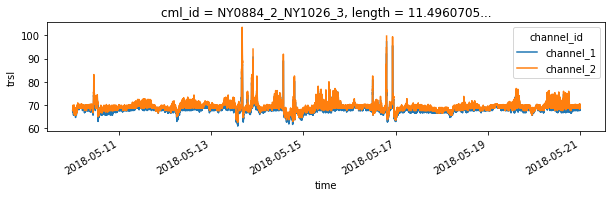

cml_id: NY1116_2_NY1084_2 wet_fraction: 0.38704028021015763


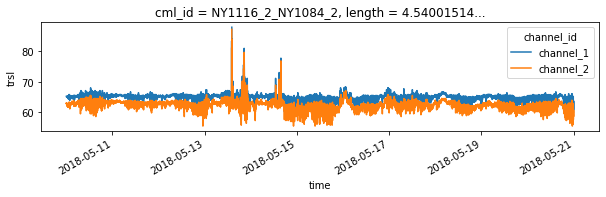

cml_id: SY0238_2_SY4411_2 wet_fraction: 0.6175644625989277


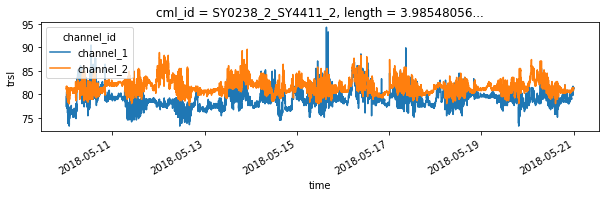

cml_id: SY2447_2_SY2452_2 wet_fraction: 0.6742416235070289


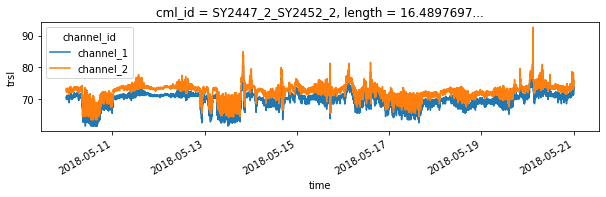

cml_id: SY2534_2_MY2336_3 wet_fraction: 0.3003858468106067


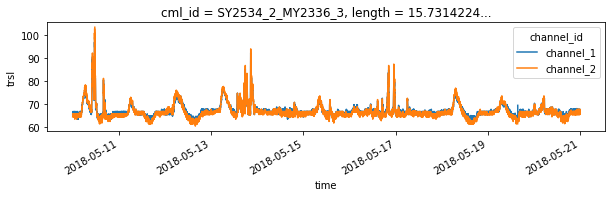

cml_id: SY2840_2_SY2346_4 wet_fraction: 0.3593066163219772


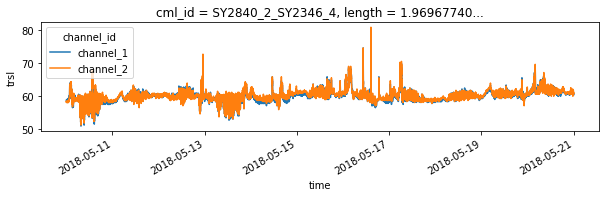

cml_id: SY3220_2_SY2409_3 wet_fraction: 0.7120622568093385


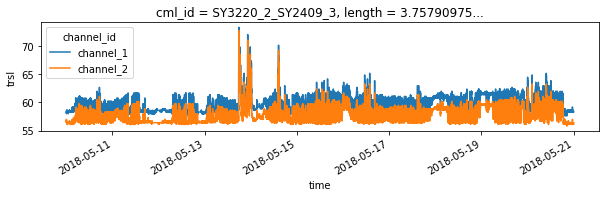

cml_id: SY4038_2_SY2263_3 wet_fraction: 0.7063449315953895


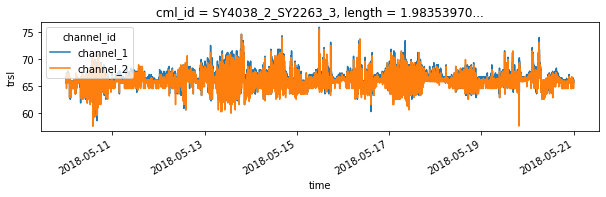

cml_id: SY5097_2_SY2500_4 wet_fraction: 0.35303664474246177


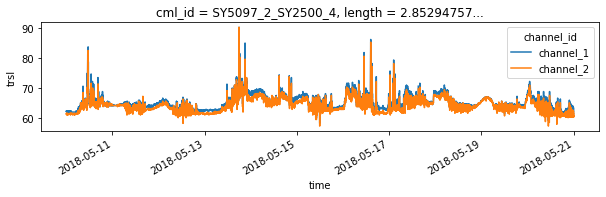

In [18]:
for cml in cml_list:
    if cml.wet_fraction > 0.3:
        print(f'cml_id: {cml.cml_id.values} wet_fraction: {cml.wet_fraction.values}')
        cml.trsl.plot.line(x='time', figsize=(10,2))
        plt.show()

# Create rainfall fields via IDW interpolation 

First, we resample the CML rain rate data from 1 minute resolution with raw time stamps (which are, in our case, not located at the full minutes) to 1-hour averages. We then combine all CMLs into one `xarray.Dataset` because it is more convenient to use in this case.

In [19]:
cmls_R_1h = xr.concat(
    objs=[cml.R.resample(time='1h', label='right').mean() for cml in cml_list if cml.wet_fraction.values < 0.3],
    dim='cml_id',
).to_dataset()

In [20]:
cmls_R_1h

<xarray.Dataset>
Dimensions:           (channel_id: 2, cml_id: 491, time: 264)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10T01:00:00 ... 2018-05-21
  * cml_id            (cml_id) object 'FY0013_2_FY1257_3' ... 'SY8534_2_SY237...
    length            (cml_id) float64 6.179 5.673 7.52 ... 8.472 14.57 4.994
    site_a_latitude   (cml_id) float64 58.26 58.09 58.19 ... 57.51 57.77 57.07
    site_a_longitude  (cml_id) float64 1.388 1.637 1.359 ... 2.022 1.471 2.09
    site_b_latitude   (cml_id) float64 58.25 58.13 58.21 ... 57.47 57.83 57.07
    site_b_longitude  (cml_id) float64 1.304 1.59 1.461 ... 2.118 1.298 2.023
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 2.491e+10 ... 2.598e+10
    polarization      (cml_id, channel_id) object 'V' 'V' 'H' ... 'V' 'V' 'V'
Data variables:
    R                 (cml_id, channel_id, time) float64 0.0 0.0 0.0 ... 0.0 0.0

Add coordinates of center location of CMLs

In [21]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

Set up the IDW interpolator

In [22]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=3, 
    exclude_nan=True, 
    max_distance=0.3,
)

Derive and plot rainfall maps of rainfall sum over period

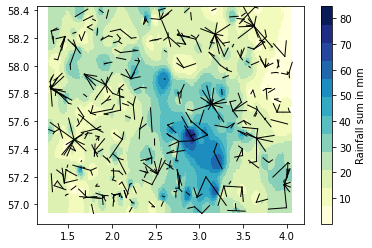

In [23]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.isel(channel_id=1).sum(dim='time'), 
    resolution=0.01,
)

fig, ax = plt.subplots()
pc = plt.pcolormesh(idw_interpolator.xgrid, idw_interpolator.ygrid, R_grid, shading='nearest', cmap=plt.get_cmap('YlGnBu', 12))
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

Plot 1-hour rainfall maps for a selected period. Note that this period was selected manually here and is selected based on the index-offset `i + 90`.

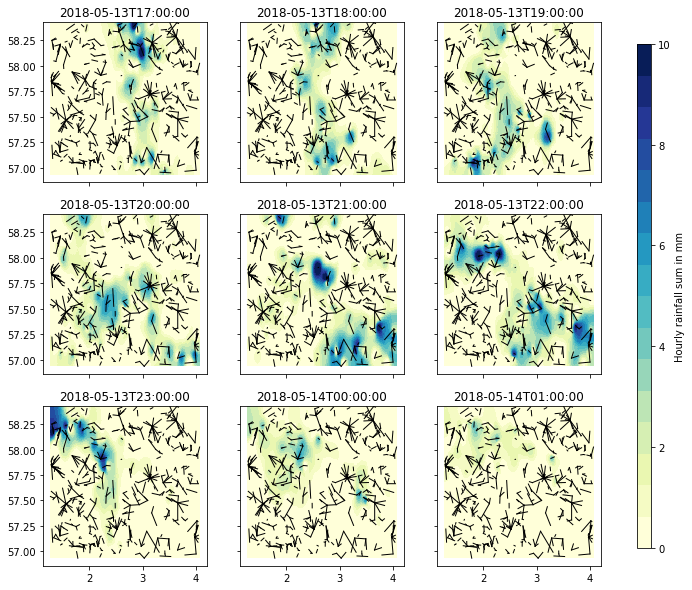

In [24]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.R.isel(channel_id=1).isel(time=i + 88), 
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=plt.get_cmap('YlGnBu', 16),
        vmin=0,
        vmax=10,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 88])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm');